In [ ]:
# default_exp select_data
from nbdev import *
%reload_ext autoreload
%autoreload 2

# Select data
> Prepare photons and exposure, given a source 

### 

In [ ]:
#export
import healpy
import pickle
import pandas as pd
import numpy as np
from wtlike.config import *
from wtlike.weights import *
from wtlike.data_man import *
from wtlike.exposure import *
from wtlike.effective_area import *

In [ ]:
# export  
def time_bin_edges(config, exposure, tbin=None):
    """Return an interleaved array of start/stop values
    
    tbin: an array (a,b,d), default config.time_bins
    
    interpretation of a, b:

        if > 50000, interpret as MJD
        if <0, back from stop
        otherwise, offset from start
        
    d : if positive, the day bin size
        if 0; return contiguous bins
        

    """
    # nominal total range, MJD edges
    start = np.round(exposure.start.values[0])
    stop =  np.round(exposure.stop.values[-1])

    a, b, step = tbin if tbin is not None else config.time_bins
    

    if a>50000: start=a
    elif a<0: start = stop+a
    else : start += a


    if b>50000: stop=b
    elif b>0: stop = start+b
    else: stop += b
    
    if step<=0:
        return contiguous_bins(exposure.query(f'{start}<start<{stop}'),)

    # adjust stop
    nbins = int((stop-start)/step)
    assert nbins>0, 'Bad binning: no bins'
    stop = start+(nbins)*step
    u =  np.linspace(start,stop, nbins+1 )
    
    # make an interleaved start/stop array
    v = np.empty(2*nbins, float)
    v[0::2] = u[:-1]
    v[1::2] = u[1:]
    return v

# export
def binned_exposure(config, exposure, time_edges):
    """Bin the exposure

    - time_bins: list of edges, as an interleaved start/stop array
       
        
    returns  array of exposure integrated over each time bin, times 1e-9
    it is interleaved, client must apply [0::2] selection.

    """

    # get exposure calculation
    exp   =exposure.exp.values
    estart= exposure.start.values
    estop = exposure.stop.values

    # determine bins,

    #use cumulative exposure to integrate over larger periods
    cumexp = np.concatenate(([0],np.cumsum(exp)) )

    # get index into tstop array of the bin edges
    edge_index = np.searchsorted(estop, time_edges)
    
    # return the exposure integrated over the intervals
    cum = cumexp[edge_index]
   
    # difference is exposure per interval: normalize it here
    bexp = np.diff(cum) 
#     if config.verbose>1:
#         print(f'Relative exposure per bin:\n{pd.Series(bexp).describe(percentiles=[])}')
    return bexp

In [ ]:
# export
def _exposure(config,  livetime, pcosine):
    """return exposure calculated for each pair in livetime and cosines arrays

    uses effective area
    """
    from scipy.integrate import simps
    assert len(livetime)==len(pcosine), 'expect equal-length arrays'

    # get a set of energies and associated weights from a trial spectrum

    emin,emax = config.energy_range
    loge1=np.log10(emin); loge2=np.log10(emax)

    edom=np.logspace(loge1, loge2, int((loge2-loge1)*config.bins_per_decade+1))
    if config.verbose>1:
        print(f'Calculate exposure using the energy domain'\
              f' {emin}-{emax} {config.bins_per_decade} bins/decade' )
    base_spectrum = eval(config.base_spectrum) #lambda E: (E/1000)**-2.1
    assert base_spectrum(1000)==1.
    wts = base_spectrum(edom)

    # effectivee area function from
    ea = EffectiveArea(file_path=config.wtlike_data/'aeff_files')

    # a table of the weighted for each pair in livetime and pcosine arrays
    rvals = np.empty([len(wts),len(pcosine)])
    for i,(en,wt) in enumerate(zip(edom,wts)):
        faeff,baeff = ea([en],pcosine)
        rvals[i] = (faeff+baeff)*wt

    aeff = simps(rvals,edom,axis=0)/simps(wts,edom)
    return (aeff*livetime)

def _calculate_exposure_for_source(config, source, week):
    """
    Calcualate the exposure for the source during the given week
    """
    df = week['sc_data']
    
    # calculate cosines with respect to sky direction
    sc = source
    ra_r,dec_r = np.radians(sc.ra), np.radians(sc.dec)
    sdec, cdec = np.sin(dec_r), np.cos(dec_r)

    def cosines( ra2, dec2):
        ra2_r =  np.radians(ra2.values)
        dec2_r = np.radians(dec2.values)
        return np.cos(dec2_r)*cdec*np.cos(ra_r-ra2_r) + np.sin(dec2_r)*sdec

    pcosines = cosines(df.ra_scz,    df.dec_scz)
    zcosines = cosines(df.ra_zenith, df.dec_zenith)
    # mask out entries too close to zenith, or too far away from ROI center
    mask =   (pcosines >= config.cos_theta_max) & (zcosines>=np.cos(np.radians(config.z_max)))
    if config.verbose>1:
        print(f'\tFound {len(mask):,} S/C entries:  {sum(mask):,} remain after zenith and theta cuts')
    dfm = df.loc[mask,:]
    livetime = dfm.livetime.values

    return  pd.DataFrame( 
        dict(
            start=df.start[mask], 
            stop=df.stop[mask], 
            exp=_exposure(config, livetime, pcosines[mask]),
            cos_theta=pcosines[mask],
        ))

In [ ]:
# export

def _get_photons_near_source(config, source, week): #tzero, photon_df):
    """
    Select the photons near a source
    
    - source : a PointSource object
    - week : dict with 
        - tzero : start time for the photon
        - photon_df : DataFrame with photon data
    
    Returns a DF with 
    - `band` index, 
    - `time` in MJD (added tstart and converted from MET)
    - `pixel` index, nest indexing 
    - `radius` distance in deg from source direction
    """
    
    def _cone(config, source, nest=True):
        # cone geometry stuff: get corresponding pixels and center vector
        l,b,radius = source.l, source.b, config.radius
        cart = lambda l,b: healpy.dir2vec(l,b, lonlat=True)
        conepix = healpy.query_disc(config.nside, cart(l,b), np.radians(radius), nest=nest)
        center = healpy.dir2vec(l,b, lonlat=True)
        return center, conepix
    
    center, conepix = _cone(config,source)

    df = week['photons']
    tstart = week['tstart']
    allpix = df.nest_index.values

    # select by comparing high-order pixels (faster)
    shift=11
    a = np.right_shift(allpix, shift)
    c = np.unique(np.right_shift(conepix, shift))
    incone = np.isin(a,c)
    
    if sum(incone)<2:
        if config.verbose>1:
            print(f'\nWeek at {UTC(MJD(tstart))} has 0 or 1 photons')
        return
    
    if config.verbose>2:
        a, b = sum(incone), len(allpix)
        print(f'Select photons for source {source.name}:\n\tPixel cone cut: select {a} from {b} ({100*a/b:.1f}%)')

    # cut df to entries in the cone
    dfc = df[incone].copy()
    
    if 'trun' in dfc:
        time = dfc.run_id.astype(float) + dfc.trun * config.offset_size
    else:
        # old: convert  to float, add tstart, convert to MJD
        time = np.array(dfc.time, float)+tstart
    dfc.loc[:,'time'] = MJD(time)

    # assemble the DataFrame, remove those outside the radius
    out_df = dfc

    # make sure times are monotonic by sorting (needed since runs not in order in most
    #  week-files after March 2018)
    out_df = dfc.sort_values(by='time')
    
    if config.verbose>2:
        print(f'selected photons:\n{out_df.head()}')
    
    return out_df

In [ ]:
# export

def get_week_files(config, week_range=None):
    """
    """  
    data_folder = config.wtlike_data/'data_files'
    data_files = sorted(list(data_folder.glob('*.pkl')))
    weeks = week_range or  config.week_range
    if week_range is not None:
#         wkr =np.atleast_1d(week_range)
#         if len(wkr)==1:
#             week_range=(wkr, wkr,None)
        slc = slice(*week_range)
        wk_table = pd.Series(data=[df for df in data_files], 
                     index= [ int(df.name[-7:-4]) for df in  data_files],
                    )
        data_files = wk_table.loc[slc].values
        
        if config.verbose>0:
            print(f'\tLoading weeks {slc}', end='' if config.verbose<2 else '\n')
    else:
        if config.verbose>0: print('loading all files', end='')
    assert len(data_files)>0, f'Specified week_range {week_range} produced no output.'
        
    return data_files

In [ ]:
# export
def process_week(config, source, week_file):
    """Process a single week file
    
    * Retrieve the file, estracting the photon and spacecraft info
    * Select photons near the source,
    * Deterine exposure for the direction
    * Add weights, selecting photons with weight info
    * Use the exposure to assign an exposure to each photon.
    * 
    
    """
    
    if config.verbose>2:
        print(f'Loading file {week_file}-----')
    with open(week_file, 'rb') as inp:
        week = pickle.load(inp)

    pdf = _get_photons_near_source(config, source, week )
    edf = _calculate_exposure_for_source(config, source, week )
    if config.verbose>2:
        print(f'\n\t-->Selected {len(photons)}')

    # add weights    
    if pdf is None or len(pdf)<3:
        return None, edf
    
    add_weights(config, pdf, source)

    if 'run_id' in pdf:
        # expint = np.empty(2*len(edf))
        estart = edf.start.values
        estop  = edf.stop.values
        exptime = np.append(estart, estop[-1])
        expval = edf.exp.values

        # corresponding cumulative exposure -- in m^2 
        cumexp = np.insert(np.cumsum(edf.exp.values/1e4), 0,0)
        # i = np.searchsorted(expint[0::2], MJD(pdf.iloc[0].run_id) )

        runs = pdf.groupby('run_id')
        last_run = 0
        tau = []
        time = []
        run_id = []
        for run, g in runs:
            assert run>last_run

            # assemble MJD time from run_id and trun
            runstart =MJD(float(run) ) 
            rtime = MJD(float(run) + g.trun*config.offset_size)
            time += list( rtime )
            # initial cumexp
            run_cumexp = cumexp[np.searchsorted(estart, runstart)]

            # use event times in this run to interpolate table of exposure times, cumexp
            event_cumexp = np.interp(rtime, exptime, cumexp)

            # diffs, from first
            event_exp = np.diff(np.insert(event_cumexp, 0, run_cumexp))

            tau += list( event_exp )
            run_id += [run]* len(g)
            last_run = run

        # update pdf
        pdf.loc[:,'tau'] = tau
        pdf.loc[:,'time'] = time
        pdf.drop(columns = 'trun', inplace=True)
        pdf.loc[:, 'run_id'] = pd.Categorical(run_id)

    return pdf, edf

In [ ]:
# export
def process_weeks(config, source, week_files):
    # check weights
    weight_file =  check_weights(config,  source)
    assert weight_file is not None
    data_folder = config.wtlike_data/'data_files'
    data_files = sorted(list(data_folder.glob('*.pkl')))
    iname = data_folder.name
    
    if config.verbose>0:
        print(f"SourceData: Assembling photon data and exposure for source {source.name}\n\tfrom"\
          f' folder "{data_folder}", with {len(data_files)} files,'\
          f'\n\tWeights from file {source.filename}_weights.pkl')
    
    # list of data framees
    pp = []
    ee = []
    for week_file in week_files:
        if config.verbose<2: print('.', end='')
        elif config.verbose>2:
            print(f'Loading file {f}-----')
        pdf, edf = process_week(config, source, week_file)
        if pdf is not None and len(pdf)>2:
            pp.append(pdf)
        if len(edf)>0:
            ee.append(edf)
    
    print('');    
    # concatenate the two lists of DataFrames
    p_df = pd.concat(pp, ignore_index=True)
    e_df = pd.concat(ee, ignore_index=True)
    return p_df, e_df

In [ ]:
# export
def load_from_weekly_data(config, source, week_range=None):
    wks = get_week_files(config, week_range)
    return process_weeks(config, source, wks)

In [ ]:
# hide
import wtlike.data_man as dm; #reload(dm)
config=Config(); config.verbose=1
dm.check_data()

# wd = WeeklyData(config, week=679)
# wd.save()

source =PointSource('Geminga')  

Weekly folder "/home/burnett/wtlike_data/data_files" contains 670 weeks.
	 Last week, # 679, has 2.3 days, ends at UTC 2021-06-05 07:50


	Loading weeks slice(9, 15, None)SourceData: Assembling photon data and exposure for source Geminga
	from folder "/home/burnett/wtlike_data/data_files", with 670 files,
	Weights from file Geminga_weights.pkl
.......
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22286 entries, 0 to 22285
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   band    22286 non-null  uint8  
 1   time    22286 non-null  float64
 2   weight  12240 non-null  float64
dtypes: float64(2), uint8(1)
memory usage: 370.1 KB
None
   band      time  weight
0     6  54682.66    0.85
1     3  54682.66     NaN
2     4  54682.66    0.95
3     1  54682.66     NaN
4     0  54682.66    0.08


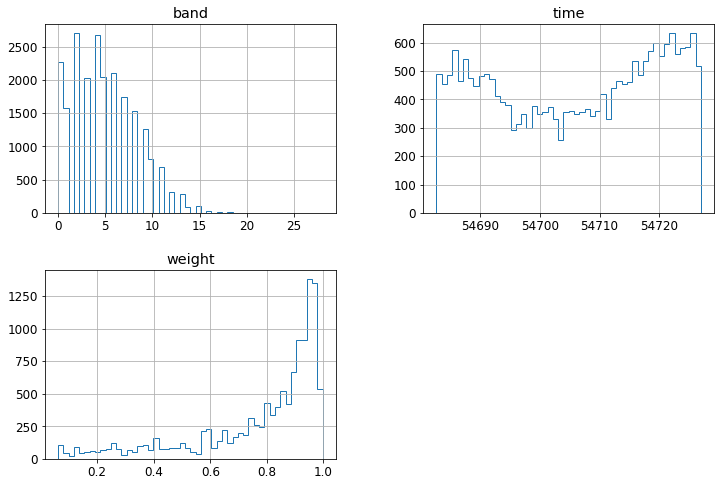

In [ ]:
pdf, edf = load_from_weekly_data(config, source, week_range=(9,15))
print(pdf.info())
print(pdf.head())
plt.rc('font', size=12,)
pdf.hist(bins=50, figsize=(12,8));

In [ ]:
#export
def update_cache(self, week_range=(-1,None), save=True):
    
    config=self.config
    source = self.source
    
    config.verbose, vsave=(2, config.verbose)
    key = f'{source.filename}_data'
    
    print(f'Retrieve photon data from cache {key}')
    cur_ph, cur_exp, cur_runs = config.cache.get(key)
    #cur_ph, cur_exp, cur_runs = current =  load_photons(config, source, clear=False)
    
    new_ph, new_exp, new_runs = tomerge = _load_from_weekly_data(config, source, week_range=(-1,None))
    
    tlast = cur_ph.iloc[-1].time 
    ph_to_append = new_ph[new_ph.time>tlast]
    
    if len(ph_to_append)==0:
        print('Up to date')
        config.verbose=vsave
        return
    print(f'photons:  {tlast:.3f} -> {ph_to_append.iloc[0].time:.3f}')
    p_df = pd.concat([cur_ph, ph_to_append])
    
    tlast = cur_exp.iloc[-1].stop
    exp_to_append = new_exp[new_exp.start>tlast]
    print(f'exposure: {tlast:.3f} -> {exp_to_append.iloc[0].start:.3f}')
    e_df  = pd.concat([cur_exp, exp_to_append])
    
    if cur_runs is None:
        print('No current runs??? Not adding' )
        runs = None
    else:
        tlast = cur_runs[-1].iloc[-1].time
        print(f'runs:     {tlast:.3f} -> {new_runs[0].iloc[0].time:.3f}')
        runs = cur_runs.append(new_runs)
    
    if save:
        print('Saving back')
        config.cache.add(key, (p_df, e_df, runs), exist_ok=True)
    else: print('not saving')
    config.vebose=vsave
    return 

### Check exposure with last data file, and our weak source

Adapt to determine exposure record for each band.

### Load the weight info for the source, get the 
* energies
* spectral function

And for each band:
The id is 2 x energy index + front(0), back(1)
* npred, 
* flux (which should be func(energy))

For each s/c entry, typically 30-s intervals
* livetime
* pcosine

The effective area function, ` ea = EffectiveArea(file_path=config.wtlike_data/'aeff_files')`
is evaluated `ea(energy, pcosine)`, and returns an effective area (front, back) tuple in $\mathrm{cm^2}$. This is then multiplied by the livetime for that interval.  






In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_weights.ipynb.
Converted 04_exposure.ipynb.
Converted 04_select_data.ipynb.
Converted 04_simulation.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Sun Jun  6 05:41:37 PDT 2021
